# Finding Adjacent Frequency Signals from Different On-Sky Targets

Noah Stiegler

7/1/24

## Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import Angle
from astropy.table import Table
from astropy.time import Time
import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array


In [2]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

In [3]:
coherent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2984740 entries, 0 to 31107169
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   signal_frequency         float64       
 2   signal_drift_rate        float64       
 3   signal_snr               float64       
 4   signal_beam              int64         
 5   signal_power             float64       
 6   signal_incoherent_power  float64       
 7   signal_num_timesteps     int64         
 8   tstart                   float64       
 9   tstart_h                 datetime64[ns]
 10  ra_hours                 float64       
 11  dec_degrees              float64       
 12  source_name              object        
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 318.8+ MB


## Find frequency "distances" between hits

### Explanation

One idea we have to find RFI is to see if the same frequency is found as a hit 
on two different parts of the sky. This would be easy if we had multiple beams
per FOV, but because this is a higher frequency observation, we don't (because
the FOV gets smaller at high frequencies and at these frequencies we don't have 
enough target density in order to get multiple targest to beamform on in an FOV)
So instead, we're going to check to see if the same exact frequency hit is found 
from different fov pointings. This is likely RFI because it's unlikely that
two different extraterrestrials are transmitting at exactly the same frequency
(within our frequency resolution of +/- 2-8 hz) and that the relative motions
of their transmitters doppler shift the signals to exactly the same frequency as
well. So if we point in one direction and see something, and point in a different
direction and see the same thing, then it's likely coming from the Earth. This is
kind of similar to what the single-dish antennas do with the ABACAD observation
pattern, except we aren't controlling the pointing so we don't know if we're going
back to the same source multiple times.

To do this computation, we're going to compute the frequency "distance" between all hits
defined as (f1 - f2). If they're the same frequency this "distance" will be small (on the
order of our frequency resolution) so we can then find the hits that are from the same
freuqencies on different parts of the sky

So we want to end up with an array which contains the difference in frequencies between all pairs of hits
To do this, I want to end up with an array which looks like

In [4]:

# a0 - b0, a0 - b1, a0 - b2, ...
# a1 - b0, a1 - b1, a1 - b2, ...
# a2 - b0, a2 - b1, a2 - b2, ...

where the vectors *a* and *b* contain the frequencies of all the hits (to compare to each other) 
Making this array is equivalent to subtracting two matrices A and B where


In [5]:
#     a0 a0 a0 ...
# A = a1 a1 a1 ...
#     a2 a2 a2 ...

#     b0 b1 b2 ...
# B = b0 b1 b2 ...
#     b0 b1 b2 ...

In [6]:
# Simple example of what I'm trying to do
a = np.array([100, 200, 300]).reshape(1, 3)
b = np.array([1, 2, 3]).reshape(1, 3)
print(a + b.T)

[[101 201 301]
 [102 202 302]
 [103 203 303]]


which we can do via numpy broadcasting
However, we can't just do this for the full coherent data, because that would be 
2.9M ^ 2 (elements in array) * 8 (bytes per element) ~= 70 Terabytes of memory :|
Even noting that (with all coherent data), a and b are the same so we can just
take the upper triangular part of the matrix, the servers don't have 35Tb of memory

So first, I am going to figure out which observational blocks are overlapping in frequency,
and then compute the distances between those points, then finally threshold distances to 
find which ones are close enough to each other to basically be the same
So I'm going to create a boolean array where C[source_1, source_2] is true if they
are overlapping in observational frequency
This array should be symmetric, with True on the diagonal, but I don't really care to 
optimize it because it'll be so small. It'll look like:


In [7]:
# Source: 1   2   3   ...   n
# 1       T   T   F
# 2       T   T   F
# 3       F   F   T
# ...
# n

### Check if bands overlap

In [8]:
# Get the bounds of the observational bands of each source
# Store them as touples of (min, max) in an array of size num_sources
# Some of the sources were observed in multiple, disjoint bands like |------|   |-----|
# bu I'll just ignore the holes for now
sources = coherent["source_name"].unique()
bands = []
for source in sources:
    hits_on_source = coherent[coherent["source_name"] == source]
    freqs = hits_on_source["signal_frequency"]
    bands.append((freqs.min(), freqs.max()))

# Create the array to store band overlap
num_sources = len(sources)
has_overlapping_band = np.full((num_sources, num_sources), False, dtype=bool)

# Compare if two bands are overlapping
# band1 and band2 are tuples (min, max) of two frequency bands
# which should be in the same units. Returns true if any part
# of the band is overlapping
def is_overlapping(band1, band2):
    # Define indices in tuple
    minimum = 0
    maximum = 1

    # Check assumption
    assert(band1[minimum] <= band1[maximum])
    assert(band2[minimum] <= band2[maximum])

    # Check if they don't overlap
    band1_below_band2_completely = (band1[maximum] < band2[minimum]) and (band1[minimum] < band2[minimum]) 
    band2_below_band1_completely = (band2[maximum] < band1[minimum]) and (band2[minimum] < band1[minimum])
    is_no_overlap = band1_below_band2_completely or band2_below_band1_completely

    return not is_no_overlap

# Fill out the overlapping bands array
for i in range(num_sources):
    for j in range(num_sources):
        has_overlapping_band[i ,j] = is_overlapping(bands[i], bands[j])

# Save the upper triangular portion of the matrix so we don't compare the same 2
# sources twice. We'll remove the diagonal for now so we don't compare hits from
# a source to itself (because we're looking for RFI that shows up on different parts
# of the sky with the same frequency)
has_overlapping_band = np.triu(has_overlapping_band, k=1) # maybe compute with diagonal too

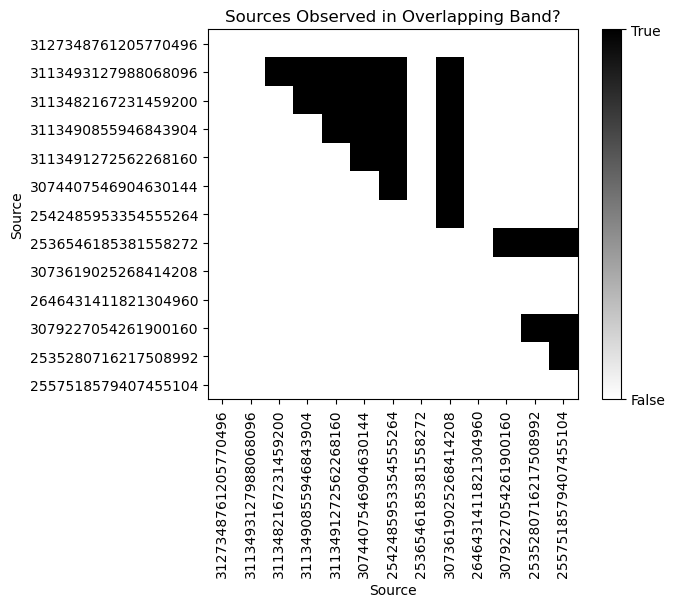

In [9]:
# Look at the array
plt.imshow(has_overlapping_band, cmap="binary")
plt.title("Sources Observed in Overlapping Band?")
plt.xlabel("Source")
plt.ylabel("Source")

# Colorbar
cbar = plt.colorbar()
cbar.set_ticks([int(False), int(True)])  # Positioning ticks at the center of each color segment
cbar.set_ticklabels(['False', 'True'])  # Setting custom tick labelsplt.xticks = sources

# Change ticks
tick_nums = np.arange(num_sources)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
plt.gca().set_xticklabels(sources, rotation='vertical')
plt.gca().set_yticklabels(sources)

plt.show()

### Estimate memory usage comparing everything from 2 overlapping sources

In [10]:
# Before we compute all the distances, let's see how much memory this is going to take up
# For two sources for which we compute distances, the resulting distance array (of floats)
# will be hits_in_source_1 * hits_in_source_2 * 8 bytes_per_float for all sources we 
# compare
items_to_compare = np.full((num_sources, num_sources), 0) # sum up the size of all arrays to get number of subtractions to perform
for i in range(num_sources):
    for j in range(num_sources):
        if has_overlapping_band[i, j]:
            indices_of_hits_in_i = coherent["source_name"] == sources[i]
            indices_of_hits_in_j = coherent["source_name"] == sources[j]
            num_hits_in_i = sum(indices_of_hits_in_i)
            num_hits_in_j = sum(indices_of_hits_in_j)
            items_to_compare[i, j] = num_hits_in_i * num_hits_in_j

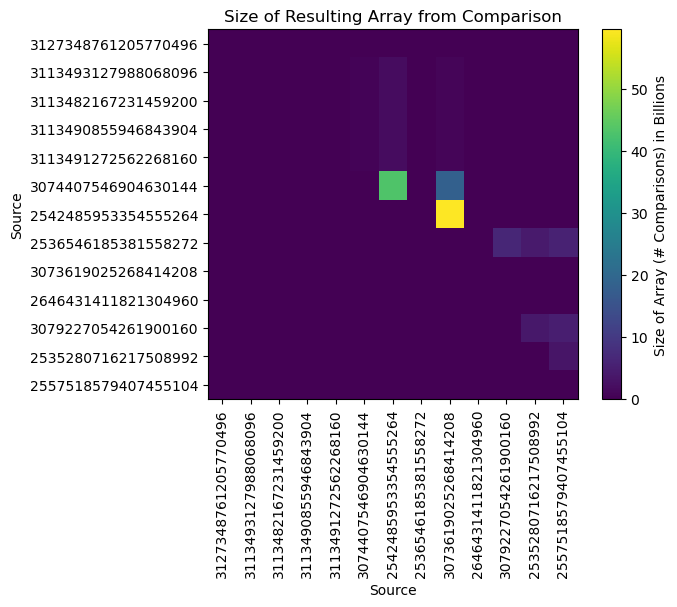

In [11]:
# Look at how much the bands overlap
# Look at the array
plt.imshow(items_to_compare / 1e9)
plt.title("Size of Resulting Array from Comparison")
plt.xlabel("Source")
plt.ylabel("Source")

# Colorbar
cbar = plt.colorbar(label="Size of Array (# Comparisons) in Billions")

# Change ticks
tick_nums = np.arange(num_sources)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
plt.gca().set_xticklabels(sources, rotation='vertical')
plt.gca().set_yticklabels(sources)

plt.show()

In [12]:
size_of_arrays = np.sum(items_to_compare)
print(f"{size_of_arrays / 1e9} giga-comparisons")
print(f"{size_of_arrays * 8 / (2**40)} TB of memory")

162.657275609 giga-comparisons
1.1834874429696356 TB of memory


In [13]:
# So this is going to take up more memory than exists on the servers if we do it all at once
# One thought might be to compute each comparison between sources and then save them out to 
# a file on the server hard drive before doing another comparison. 
# However, maybe we can be smarter. It's possible that the whole frequency band doesn't overlap
# If we can find ways to not compare items, then that reduces the size of our arrays by N^2 which
# is pretty good

In [14]:
# So let's be a little smarter. Instead of looking at whether the bands overlap,
# let's look at how much of the bands overlap and how many hits are in each overlap

### Check how much of a band overlaps

In [15]:
# Find how much of each band overlaps
# Define an array that holds how much of the band overlaps between two sources
overlap_bandwidths = np.full((num_sources, num_sources), 0) # The frequencies are stored in MHz
overlap_bands = np.full((num_sources, num_sources), None, dtype='object')

# Compute overlap band
# band1 and band2 are tuples (min, max) of two frequency bands
# which should be in the same units. I assume the bands are 
# overlapping
# Returns a tuple (min, max) of the region of overlap
def compute_band_overlap(band1, band2):
    # Check assumption
    assert(is_overlapping(band1, band2))

    # Define indices
    minimum = 0
    maximum = 1

    # Get lower boundary of overlap region
    lower_bound = max(band1[minimum], band2[minimum])
    upper_bound = min(band1[maximum], band2[maximum])

    return (lower_bound, upper_bound)

# For each band which overlaps, look by how much
for i in range(num_sources):
    for j in range(num_sources):
        if has_overlapping_band[i, j]:
             overlap_band = compute_band_overlap(bands[i], bands[j])
             overlap_bands[i, j] = overlap_band
             overlap_bandwidths[i, j] = overlap_band[1] - overlap_band[0]

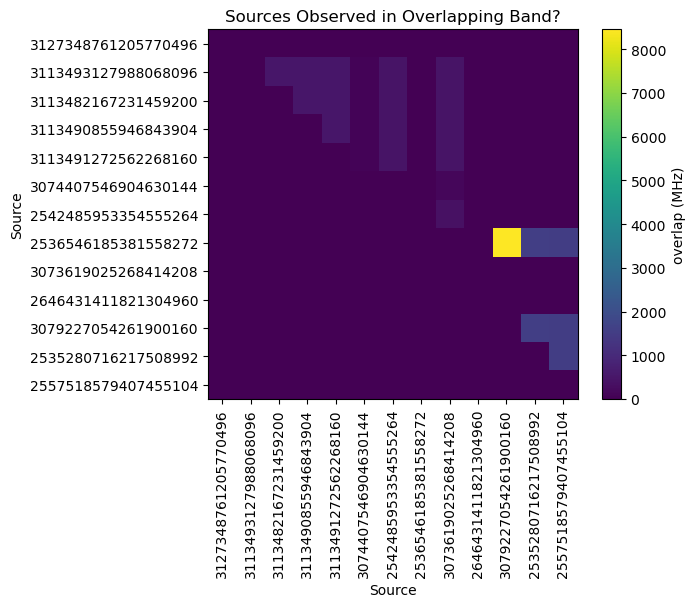

In [16]:
# Look at how much the bands overlap
# Look at the array
plt.imshow(overlap_bandwidths)
plt.title("Sources Observed in Overlapping Band?")
plt.xlabel("Source")
plt.ylabel("Source")

# Colorbar
cbar = plt.colorbar(label="overlap (MHz)")

# Change ticks
tick_nums = np.arange(num_sources)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
plt.gca().set_xticklabels(sources, rotation='vertical')
plt.gca().set_yticklabels(sources)

plt.show()

### Estimate memory usage comparing only overlapping sections of bands from 2 sources

In [17]:
# So let's recompute how many elements we need to compare given that we don't have to compare
# the full range of each band
# Before we compute all the distances, let's see how much memory this is going to take up
# For two sources for which we compute distances, the resulting distance array (of floats)
# will be hits_in_source_1 * hits_in_source_2 * 8 bytes_per_float for all sources we 
# compare
items_to_compare = np.full((num_sources, num_sources), 0) # sum up the size of all arrays to get number of subtractions to perform
for i in range(num_sources):
    for j in range(num_sources):
        if has_overlapping_band[i, j]:
            # Compute the indices of the hits which are in the source and overlap
            overlap_band = overlap_bands[i, j]
            indices_in_overlap = (coherent["signal_frequency"] < overlap_band[1]) & (coherent["signal_frequency"] > overlap_band[0])
            indices_of_hits_in_i = (coherent["source_name"] == sources[i]) & indices_in_overlap
            indices_of_hits_in_j = (coherent["source_name"] == sources[j]) & indices_in_overlap
            num_hits_in_i = sum(indices_of_hits_in_i)
            num_hits_in_j = sum(indices_of_hits_in_j)
            items_to_compare[i, j] = num_hits_in_i * num_hits_in_j

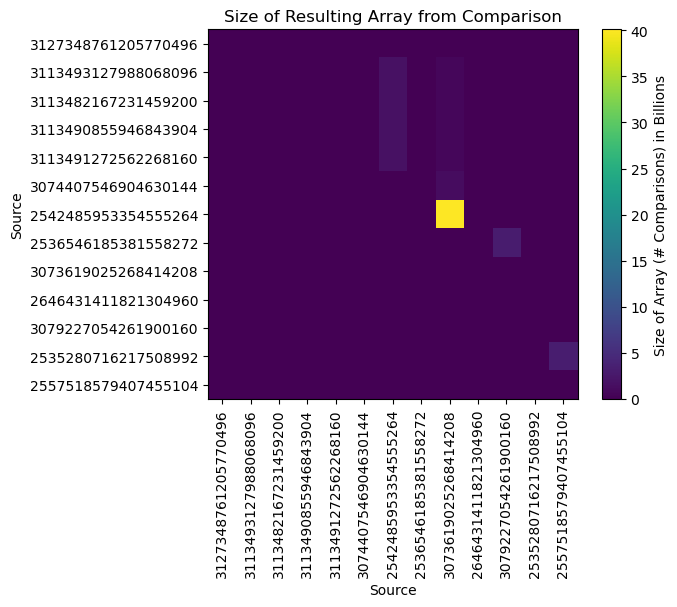

In [18]:
# Look at how much the bands overlap
# Look at the array
plt.imshow(items_to_compare / 1e9)
plt.title("Size of Resulting Array from Comparison")
plt.xlabel("Source")
plt.ylabel("Source")

# Colorbar
cbar = plt.colorbar(label="Size of Array (# Comparisons) in Billions")

# Change ticks
tick_nums = np.arange(num_sources)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
plt.gca().set_xticklabels(sources, rotation='vertical')
plt.gca().set_yticklabels(sources)

plt.show()

In [19]:
size_of_arrays = np.sum(items_to_compare)
print(f"{size_of_arrays / (2**30)} giga-comparisons")
print(f"{size_of_arrays * 8 / (2**30)} GB of memory")

53.809834593907 giga-comparisons
430.478676751256 GB of memory


### Estimate memory usage comparing overlapping parts of bands and dividing each one into 32MHz chunks

In [20]:
# So we're going to do the same computation as above, but for any 
# overlap bandwidth larger than 32MHz, we're going to break it up
# into 32MHz chunks

In [21]:

# To make this more modular, I'll break up the calculation of how many hits are in a band from a
# pair of sources
# Given an overlap band (tuple (min_frequency_in_band, max_frequency_in_band))
# and indices of the sources i and j, returns the size of the array that
# would be created to compare all hits in that band for those sources
def compute_number_of_comparisons(overlap_band, i, j):
    # Compute the indices of the hits which are in this frequency band
    indices_in_overlap = (coherent["signal_frequency"] < overlap_band[1]) & (coherent["signal_frequency"] > overlap_band[0])
    
    # Find hits of those which are from each target
    indices_of_hits_in_i = (coherent["source_name"] == sources[i]) & indices_in_overlap
    indices_of_hits_in_j = (coherent["source_name"] == sources[j]) & indices_in_overlap

    # Get the number of hits satisfying all criteria
    num_hits_in_i = sum(indices_of_hits_in_i)
    num_hits_in_j = sum(indices_of_hits_in_j)

    # Compue number of items to compare
    return num_hits_in_i * num_hits_in_j

# Divide up the overlap band into chunks of a certain size
# and return a list of smaller overlap band chunks to
# perform the calculations over which looks like:
# [(min, max), (min, max), (min, max), ...]
def compute_chunks(overlap_band, chunk_size):
    chunks = [] # List of tuples to return
    min_of_current_chunk = overlap_band[0] # The bottom frequency of the chunk we're currently creating
    bandwidth_left_to_chunk = overlap_band[1] - overlap_band[0] # How much of the bandwidth is left to divide up
    # Divide bandwidth into chunks until there's nothing left
    while bandwidth_left_to_chunk > 0:
        chunks.append((min_of_current_chunk, min_of_current_chunk + chunk_size))
        min_of_current_chunk += chunk_size # Next chunk starts chunk_size higher
        bandwidth_left_to_chunk -= chunk_size
    return chunks

# Now each element in the array is a list. Each 32MHz chunk we process
# will get appended as a number of comparisons to this list along with the
# band min/max as a tuple ((min, max), num_comparisons)
chunk_size = 32 # MHz
comparisons = np.full((num_sources, num_sources), None, dtype='object') 
for i in range(num_sources):
    for j in range(num_sources):
        if has_overlapping_band[i, j]:
            comparisons[i, j] = [] # np wouldn't let me fill an array w/empty lists, so assign list here
            # Perform the comparison for each 32MHz chunk
            overlap_band = overlap_bands[i, j]
            overlap_band_chunks = compute_chunks(overlap_band, chunk_size)
            for overlap_band_chunk in overlap_band_chunks:
                to_compare = compute_number_of_comparisons(overlap_band_chunk, i, j)
                comparisons[i, j].append((overlap_band, to_compare))
            print(f"Finished ({i, j})")

Finished ((1, 2))
Finished ((1, 3))
Finished ((1, 4))
Finished ((1, 5))
Finished ((1, 6))
Finished ((1, 8))
Finished ((2, 3))
Finished ((2, 4))
Finished ((2, 5))
Finished ((2, 6))
Finished ((2, 8))
Finished ((3, 4))
Finished ((3, 5))
Finished ((3, 6))
Finished ((3, 8))
Finished ((4, 5))
Finished ((4, 6))
Finished ((4, 8))
Finished ((5, 6))
Finished ((5, 8))
Finished ((6, 8))
Finished ((7, 10))
Finished ((7, 11))
Finished ((7, 12))
Finished ((10, 11))
Finished ((10, 12))
Finished ((11, 12))


In [22]:
# Try to visualize comparisons
comparison_list_sizes = np.full((num_sources, num_sources), 0) # How many chunks were computed for each pair of sources
comparison_sizes = np.full((num_sources, num_sources), 0) # How many total comparisons we'll have to do for each pair
total_comparisons = 0
for i in range(num_sources):
    for j in range(num_sources):
        if comparisons[i, j] != None:
            # Unpack comparison
            comparison = comparisons[i, j]
            chunks = [entry[0] for entry in comparison]
            number_of_comparisons = [entry[1] for entry in comparison]

            # Update visualizations
            comparison_list_sizes[i, j] = len(comparisons[i, j])
            comparison_sizes[i, j] = sum(number_of_comparisons)

            # Update number of comparisons performed
            total_comparisons += comparison_sizes[i, j]

# Print information
size_of_arrays = np.sum(comparison_sizes)
print(f"{size_of_arrays / (2**30)} giga-comparisons")
print(f"{size_of_arrays * 8 / (2**30)} GB of memory")

4.143312256783247 giga-comparisons
33.146498054265976 GB of memory


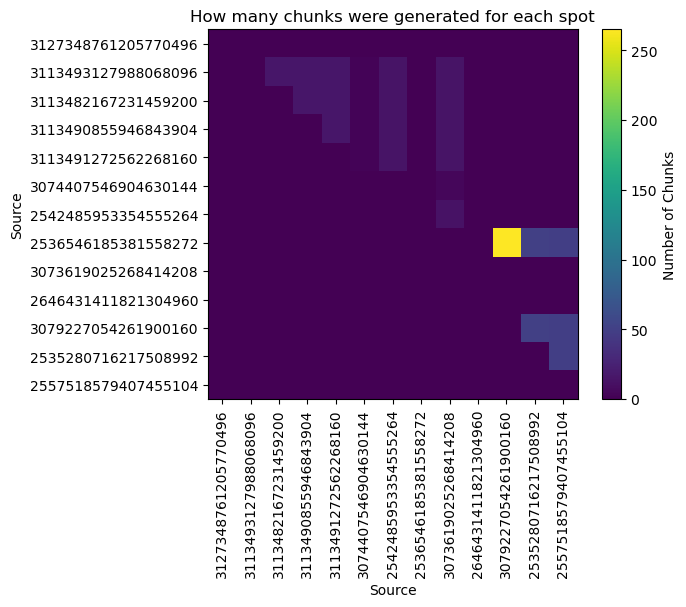

In [23]:
# Look at the array
plt.imshow(comparison_list_sizes)
plt.title("How many chunks were generated for each spot")
plt.xlabel("Source")
plt.ylabel("Source")

# Colorbar
cbar = plt.colorbar(label="Number of Chunks")

# Change ticks
tick_nums = np.arange(num_sources)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
plt.gca().set_xticklabels(sources, rotation='vertical')
plt.gca().set_yticklabels(sources)

plt.show()

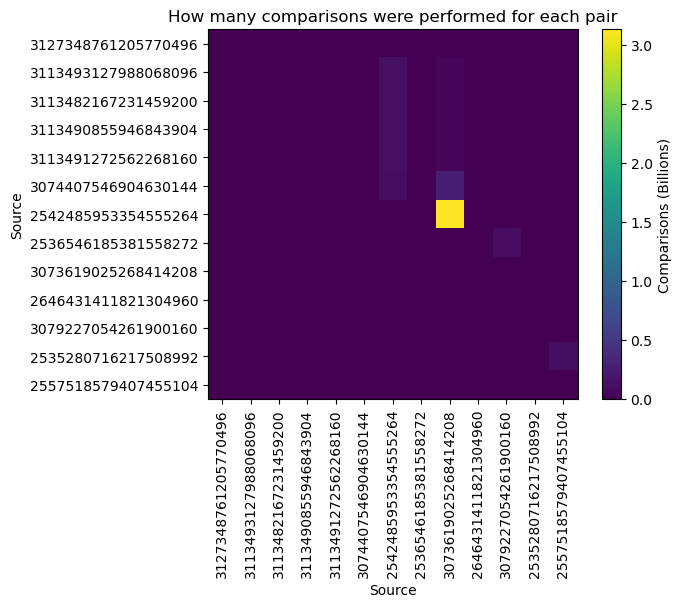

In [24]:
# Look at the array
plt.imshow(comparison_sizes / 1e9)
plt.title("How many comparisons were performed for each pair")
plt.xlabel("Source")
plt.ylabel("Source")

# Colorbar
cbar = plt.colorbar(label="Comparisons (Billions)")

# Change ticks
tick_nums = np.arange(num_sources)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
plt.gca().set_xticklabels(sources, rotation='vertical')
plt.gca().set_yticklabels(sources)

plt.show()